
### 1. This file contains the code for our algorithm and for GDA, for the CIFAR dataset. For our algorithm with acceptance rate 1/2, set the "rate" paramter to "rate = 2"

### 2. This file contains the code for our algorithm and for GDA, for the MNIST dataset. For our algorithm with acceptance rate 1/5, set the "rate" paramter to "rate = 5".
##


### we will start will the MNIST dataset


### Training using the Keswani paper


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

  # Keras / TensorFlow imports
import tensorflow as tf
tf.config.run_functions_eagerly(True)  # Enable eager execution
tf.data.experimental.enable_debug_mode()
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
  #from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras import backend

  # tqdm for progress bars
from tqdm.notebook import tqdm

  # Matplotlib for plotting
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.image import imread

  # NumPy for data manipulation
from numpy import expand_dims, mean, ones
from numpy.random import randn, randint

  # Optional: Functionality to load MNIST data
from tensorflow.keras.datasets.mnist import load_data


batch_size = 64
  #### ____________________________ #####


  # The Players class defines the two-player game and all necessary update functions
  # x - min player
  # y - max player
  # f - a function of x, y to create new entity z
  # u_x - function to take gradient update step of min player x
  # u_y - function to take gradient update step of max player y
  # c_x - function to change value of x to x_new
  # c_y - function to change value of y to y_new
  # p_x - function to perturb value of x along a random normal direction

class Players:
    def __init__(self, x, y, f, u_x, u_y, c_x, c_y, p_x):
          self.x = x
          self.y = y
          if f == None:
              self.z = None
          else:
              self.z = f(x, y)
          self.u_x = u_x
          self.u_y = u_y
          self.c_x = c_x
          self.c_y = c_y
          self.p_x = p_x

    def value(self, f):
          return f(self.x, self.y)

    def get_x(self):
          return self.x

    def get_y(self):
          return self.y

    def update_x(self):
          self.x = self.u_x(self.x, self.y, self.z)
          return self.x

    def update_y(self):
          self.y = self.u_y(self.x, self.y, self.z)
          return self.y

    def change_x(self, x_new):
          self.x = self.c_x(self.x, x_new)

    def change_y(self, y_new):
          self.y = self.c_y(self.y, y_new)

    def perturb_x(self):
          self.x = self.p_x(self.x)
          return self.x


def getGDopt(lr = 0.01):
      lr = float(lr)
      return SGD(lr)

  # Load Mnist data
def load_data(filter=False, balanced=True):
      (x_train, y_train), (x_test, y_test) = mnist.load_data()
      x_train = (x_train.astype(np.float32) - 127.5)/127.5
      x_train = x_train.reshape(len(x_train), 784)

      x_test = (x_test.astype(np.float32) - 127.5)/127.5
      x_test = x_test.reshape(len(x_test), 784)

    #   # restricting to digits 0 and 1
    #   if filter:
    #       train_filter = np.where((y_train == 0 ) | (y_train == 1))
    #       x_train, y_train = x_train[train_filter], y_train[train_filter]

    #       test_filter = np.where((y_test == 0 ) | (y_test == 1))
    #       x_test, y_test = x_test[test_filter], y_test[test_filter]

    #   if balanced and filter:
    #       f = np.where(y_train == 0)
    #       x_train_0, y_train_0 = x_train[f], y_train[f]
    #       f = np.where(y_train == 1)
    #       x_train_1, y_train_1 = x_train[f], y_train[f]

    #       if len(y_train_1) > len(y_train_0):
    #           n = len(y_train_0)
    #       else:
    #           n = len(y_train_1)

    #       x_train = np.array(list(x_train_0[:n]) + list(x_train_1[:n]))
    #       y_train = np.array(list(y_train_0[:n]) + list(y_train_1[:n]))

      return (x_train, y_train, x_test, y_test)

  # (X_train, y_train, X_test, y_test) = load_data()
  # X_train = np.array([img]*128)

  # Create generator network with preferred optimization function
def create_generator(OUTPUT_SIZE, opt=getGDopt(), INPUT_SIZE=100, loss='binary_crossentropy'):
        generator = Sequential()
        # Increase initial layer size for better representation
        generator.add(Dense(units=512, input_shape=(INPUT_SIZE,)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(0.2))

        generator.add(Dense(units=1024))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(0.2))

        generator.add(Dense(units=2048))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(0.2))

        # Final layer
        generator.add(Dense(units=OUTPUT_SIZE, activation='tanh'))

        # Force build the model with dummy input
        dummy_input = np.zeros((1, INPUT_SIZE))
        output = generator(dummy_input)
        print(f"Generator built successfully. Output shape: {output.shape}")

        # Create a new optimizer instance for this specific model
        if opt is None:
            opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

        generator.compile(loss=loss, optimizer=opt)
        return generator
def create_discriminator(INPUT_SIZE, opt=getGDopt(), loss='binary_crossentropy'):
    discriminator = Sequential()
    discriminator.add(Dense(units=1024, input_shape=(INPUT_SIZE,)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.4))  # Increase dropout for better regularization

    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.4))

    discriminator.add(Dense(units=256))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    dummy_input = np.zeros((1, INPUT_SIZE))
    output = discriminator(dummy_input)
    print(f"Discriminator built successfully. Output shape: {output.shape}")

    if loss=='binary_crossentropy':
        discriminator.add(Dense(units=1, activation='sigmoid'))
    else:
        discriminator.add(Dense(units=1))

    discriminator.trainable = True

    if opt is None:
        opt = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)

    discriminator.compile(loss=loss, optimizer=opt)
    return discriminator

def create_gan(generator, discriminator, opt=getGDopt(lr=0.01), loss='binary_crossentropy'):
      # The key point here: we need to make a copy of the discriminator
      # Creating a new model to avoid the "never been called" error

        # First, make sure both models are built
      if not hasattr(generator, '_built') or not generator._built:
          dummy_noise = np.zeros((1, generator.input_shape[1]))
          _ = generator(dummy_noise)

      # First, make sure discriminator is built
      if not hasattr(discriminator, '_built') or not discriminator._built:
          dummy_img = np.zeros((1, discriminator.input_shape[1]))
          _ = discriminator(dummy_img)

      # Create the GAN model properly
      gan_input = Input(shape=(generator.input_shape[1],))
      discriminator.trainable = False
      gen_output = generator(gan_input)
      gan_output = discriminator(gen_output)

      # Create and compile the combined model
      gan = Model(inputs=gan_input, outputs=gan_output)

      # Set discriminator non-trainable in this model


      #     # Compile GAN
      # if opt is None:
      #     opt = keras.optimizers.Adam(0.0002, 0.5)
      # gan.compile(loss='binary_crossentropy', optimizer=opt)

          # Use a new optimizer instance
      if opt is None:
          opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)



      if loss == 'binary_crossentropy':
          gan.compile(loss='binary_crossentropy', optimizer=opt)
      else:
          gan.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])

      # Call the model once to ensure it's built
      dummy_noise = np.zeros((1, generator.input_shape[1]))
      _ = gan(dummy_noise)
      print("GAN model built successfully")

      return gan

  # gradient update steps for discriminator
def take_discriminator_steps(generator, discriminator, gan, X_train, k=1, NOISE_SIZE=100):
      for _ in range(k):

          noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
          generated_images = generator.predict(noise)

          image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]

          X= np.concatenate([image_batch, generated_images])

          y_dis = np.zeros(2*batch_size)
          y_dis[:batch_size] = 0.9

          discriminator.trainable=True
          loss = discriminator.train_on_batch(X, y_dis)

      return discriminator

  # gradient update steps for discriminator
def take_discriminator_steps_wgan(generator, discriminator, gan, X_train, k=1, NOISE_SIZE=100, clip=False, clip_value=None):
      for _ in range(k):
          if clip and clip_value is not None:
              for layer in discriminator.layers:
                  weights = layer.get_weights()
                  weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                  layer.set_weights(weights)


          noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
          generated_images = generator.predict(noise)

          image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]

          X= np.concatenate([image_batch, generated_images])

          y_dis = np.ones(2*batch_size)
          y_dis[:batch_size] = -1

          discriminator.trainable=True
          loss = discriminator.train_on_batch(X, y_dis)
  #         print ("D-loss", loss)

      return discriminator

  # perturbing weights of the generator
def perturb_generator(generator, sigma=0.001):
      weights, u = [], []
      for wt in generator.get_weights():
          u.append(np.random.normal(0, 1, wt.shape))
          wt = wt + u[-1] * sigma
          weights.append(wt)

      generator.set_weights(weights)

      return generator

  # gradient update steps for generator
def take_generator_steps(generator, discriminator, gan, NOISE_SIZE=100):
      noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
      generated_images = generator.predict(noise)

  #     gan = create_gan(discriminator, generator)

      y_gen = np.ones(batch_size)
      discriminator.trainable=False
      loss = gan.train_on_batch(noise, y_gen)
  #     print ("G-loss", loss)

      return generator

def take_generator_steps_wgan(generator, discriminator, gan, NOISE_SIZE=100):
      noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
      generated_images = generator.predict(noise)

      y_gen = -np.ones(batch_size)
      discriminator.trainable=False
      loss = gan.train_on_batch(noise, y_gen)
  #     print ("G-loss", loss)

      return generator

def change_network(modela, modelb):
      modela.set_weights(modelb.get_weights())
      return modela

def wasserstein_loss(y_true, y_pred):
      return backend.mean(y_true * y_pred)

def getLoss(generator, discriminator, X_train, NOISE_SIZE=100, eps=0):

      noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
      image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
      generated_images = generator.predict(noise)

      probabilities_1 = discriminator.predict(image_batch).reshape(len(image_batch))
      probabilities_1 = np.log(probabilities_1 + eps)

      probabilities_2 = discriminator.predict(generated_images).reshape(len(generated_images))
      probabilities_2 = np.log(1 - probabilities_2 + eps)

      return np.mean(probabilities_1) + np.mean(probabilities_2)

def getWassersteinLoss(generator, discriminator, X_train, NOISE_SIZE=100, eps=0):

      noise= np.random.normal(0,1, [batch_size, NOISE_SIZE])
      image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
      generated_images = generator.predict(noise)

      disc_1 = discriminator.predict(image_batch).reshape(len(image_batch))
      disc_2 = discriminator.predict(generated_images).reshape(len(generated_images))
      y_pred = np.array(list(disc_1) + list(disc_2))
      y_true = np.ones(2*batch_size)
      y_true[:batch_size] = -1

      loss = np.mean(y_true*y_pred)
      return loss

def getLossFixedBatch(generator, discriminator, image_batch, generated_images):

      probabilities_1 = discriminator.predict(image_batch).reshape(len(image_batch))
      probabilities_1 = np.log(probabilities_1) / np.log(2)

      probabilities_2 = discriminator.predict(generated_images).reshape(len(generated_images))
      probabilities_2 = np.log(1 - probabilities_2) / np.log(2)

      return np.mean(probabilities_1) + np.mean(probabilities_2)


  # Creating a GAN player object
def create_GAN_player():
      print("HELLO")
      ganPlayer = Players(create_generator(), create_discriminator(), create_gan, take_generator_steps, take_discriminator_steps, change_network, change_network, perturb_generator)
      return ganPlayer


def plot_generated_images(epoch, generator, folder="", save = False, image_shape=(28,28), examples=100, dim=(10,10), figsize=(10,10),name=""):
      print ("Iteration " + str(epoch))
      noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
      generated_images = generator.predict(noise)
      generated_images = generated_images.reshape(examples,image_shape[0], image_shape[1])
      plt.figure(figsize=figsize)
      for i in range(generated_images.shape[0]):
          plt.subplot(dim[0], dim[1], i+1)
          plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
          plt.axis('off')
      plt.tight_layout()
      plt.show()
      if save:
          plt.savefig(folder+name %epoch)

  ######################################################################


  # select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    y = -ones((n_samples, 1))
    return X, y

  # generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

  # use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = ones((n_samples, 1))
    return X, y

  # generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
      # define subplot
      plt.subplot(10, 10, 1 + i)
      # turn off axis
      plt.axis('off')
      # plot raw pixel data
      plt.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

  # create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.close()



In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam  # SGD can also be imported from here if needed
from tensorflow.keras import backend as K
import sys
sys.path.append("../")

# from utils_Picky_grayscale import *       # utils file has the filler code and helper functions

from tqdm.notebook import tqdm
from functools import partial


#set filter = true to include only the digits "0" and "1" in the MNIST dataset
X, y, X_test, y_test = load_data(filter=False, balanced=False)



NOISE_SIZE = 100
IMAGE_SIZE = 784


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X, y)
clf.score(X_test, y_test)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


0.9254

In [3]:
from scipy.linalg import sqrtm
from sklearn.metrics import pairwise_distances

# Add functions to calculate FID score and Inception Score (simplified versions for MNIST)
def calculate_fid(real_images, generated_images, feature_extractor=None):
    """
    Improved FID calculation with better numerical stability and feature extraction
    """
    # Optional feature extraction using a pre-trained model
    if feature_extractor is not None:
        real_features = feature_extractor.predict(real_images)
        gen_features = feature_extractor.predict(generated_images)
    else:
        # Reshape images if needed and normalize
        if len(real_images.shape) == 4:
            real_features = real_images.reshape(real_images.shape[0], -1)
            gen_features = generated_images.reshape(generated_images.shape[0], -1)
        else:
            real_features = real_images
            gen_features = generated_images

    # Ensure we have enough samples for covariance calculation
    min_samples = min(real_features.shape[0], gen_features.shape[0])
    real_features = real_features[:min_samples]
    gen_features = gen_features[:min_samples]

    # Calculate mean and covariance with better numerical stability
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    # Add regularization to covariance matrices to ensure they're invertible
    sigma1 += np.eye(sigma1.shape[0]) * 1e-6
    sigma2 += np.eye(sigma2.shape[0]) * 1e-6

    # Calculate squared difference between means
    diff = mu1 - mu2
    diff_sq = np.sum(diff**2)

    # Calculate sqrt of product of covariances more stably
    # We use the fact that sqrt(A*B) can be calculated using SVD
    try:
        covmean = sqrtm(sigma1.dot(sigma2))
        # Check and correct imaginary component if necessary
        if np.iscomplexobj(covmean):
            covmean = covmean.real
    except ValueError:
        # If sqrtm fails, use a more stable approach
        sigma1_sqrt = sqrtm(sigma1)
        sigma2_sqrt = sqrtm(sigma2)
        covmean = sigma1_sqrt.dot(sigma2_sqrt)

    # Calculate FID
    trace_term = np.trace(sigma1 + sigma2 - 2 * covmean)
    fid = diff_sq + trace_term

    return fid
def calculate_inception_score(generated_images, clf, n_split=10):
    """
    Calculate Inception Score using a classifier (simplified for MNIST).

    Args:
        generated_images: Sample of generated images
        clf: Classifier model that predicts class probabilities
        n_split: Number of splits for calculating IS (default: 10)

    Returns:
        Inception Score (higher is better)
    """
    # Get predictions using the classifier
    probs = clf.predict_proba(generated_images)

    # Calculate IS score
    # Split images into n_split groups
    n_samples = generated_images.shape[0]
    split_size = n_samples // n_split
    scores = []

    for i in range(n_split):
        start = i * split_size
        end = start + split_size
        part = probs[start:end]

        # Calculate KL divergence
        p_y = np.mean(part, axis=0, keepdims=True)
        kl = part * (np.log(part + 1e-10) - np.log(p_y + 1e-10))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))

    # Return mean and standard deviation
    return np.mean(scores), np.std(scores)

In [4]:
def plot_generated_images(epoch, generator, save=False, examples=25, dim=(5, 5), figsize=(10, 10), calculate_metrics=True):
    """
    Plot generated images and calculate FID & IS metrics using the provided functions.

    Args:
        epoch: Current training epoch/iteration
        generator: Generator model
        save: Whether to save the figure to disk
        examples: Number of examples to display in the plot
        dim: Dimensions of the plot grid
        figsize: Figure size
        calculate_metrics: Whether to calculate FID and IS metrics
    """
    # Generate images for display
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise, verbose=0)

    # For metrics calculation, we need more images
    if calculate_metrics:
        # Generate a larger batch for metrics calculation (1000 images)
        noise_metrics = np.random.normal(loc=0, scale=1, size=[1000, 100])
        generated_images_metrics = generator.predict(noise_metrics, verbose=0)

        # Sample real images for comparison
        # If X is global and accessible, sample 1000 random real images
        indices = np.random.choice(X.shape[0], 1000, replace=False)
        real_images_sample = X[indices]

        # Calculate FID
        fid_value = calculate_fid(real_images_sample, generated_images_metrics)

        # Calculate Inception Score using the classifier (clf) that was defined earlier
        # Pass 10 as the n_split argument instead of clf to fix the TypeError
        is_mean, is_std = calculate_inception_score(generated_images_metrics, clf, n_split=10)

        # Print the metrics
        print(f"Epoch {epoch}:")
        print(f"  - FID Score: {fid_value:.4f} (lower is better)")
        print(f"  - Inception Score: {is_mean:.4f} ± {is_std:.4f} (higher is better)")

    # Plot the generated images
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        img = generated_images[i].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    if save:
        plt.savefig(f'gan_generated_image_epoch_{epoch}.png')

    plt.show()

    # Return metrics if they were calculated
    if calculate_metrics:
        return generated_images, fid_value, is_mean, is_std
    return generated_images

In [5]:
def training_gd_mx(create_player_function, create_player_function2, T=3000):
    print("THE ALGO HAS STARTED.")

    # Create Players objects
    player = create_player_function()
    player2 = create_player_function2()

    losses, ones = [], []
    fid_scores, is_means, is_stds = [], [], []

    # Modify the rate parameter - this controls accept/reject frequency
    rate = 5  # This seems to be working for your MNIST case

    # Initialize player states
    player.update_y()

    for j in (range(1, T+1)):
        # Compute current loss
        loss = player.value(getLoss2)
        losses.append(loss)

        # Save current state if needed for accept/reject step
        if j % rate != 0:
            player2.change_x(player.get_x())
            player2.change_y(player.get_y())
            loss_old = player.value(getLoss2)

        # Perform gradient updates
        player.update_x()
        player.update_y()

        # Accept/reject step with probability depending on loss difference
        if j % rate != 0:
            loss_new = player.value(getLoss2)

            # Implement a probabilistic acceptance criterion
            # The higher the loss increase, the lower the chance of acceptance
            if loss_new > loss_old:
                # Calculate acceptance probability based on relative loss increase
                accept_prob = np.exp(-(loss_new - loss_old) / 0.1)  # Temperature parameter

                if np.random.random() > accept_prob:
                    print(f"Iteration {j}: Reject (Loss {loss_new:.4f} > {loss_old:.4f})")
                    player.change_x(player2.get_x())
                    player.change_y(player2.get_y())
                else:
                    print(f"Iteration {j}: Accept despite loss increase ({accept_prob:.2f} probability)")
            else:
                print(f"Iteration {j}: Accept (Loss {loss_new:.4f} <= {loss_old:.4f})")

        # Monitor progress
        if j % 10 == 0:
            noise = np.random.normal(loc=0, scale=1, size=[1000, 100])
            generated_images = player.get_x().predict(noise, verbose=0)

            # Check for valid predictions
            predictions = player.get_y().predict(generated_images, verbose=0)
            if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                print("Warning: NaN or Inf detected in predictions!")
                predictions = np.nan_to_num(predictions, nan=0.0, posinf=1.0, neginf=0.0)

            o = np.mean(predictions)
            ones.append(o)

        # Periodic visualization and metrics
        if j % 100 == 0:
            # Calculate metrics and save/display images
            result = plot_generated_images(j, player.get_x(), save=True,
                                          examples=25, dim=(5,5), figsize=(5,5),
                                          calculate_metrics=True)

            if len(result) == 4:
                _, fid_value, is_mean, is_std = result
                fid_scores.append(fid_value)
                is_means.append(is_mean)
                is_stds.append(is_std)

    return player, losses, ones, fid_scores, is_means, is_stds

  0%|          | 0/5 [00:00<?, ?it/s]


Starting repetition 1/5
THE ALGO HAS STARTED.
Creating GAN player...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator built successfully. Output shape: (1, 784)
Generator created with input shape: (None, 100)
Discriminator built successfully. Output shape: (1, 256)
Discriminator created with input shape: (None, 784)
Creating Players object...
GAN model built successfully
Players object created successfully
Creating GAN player...
Generator built successfully. Output shape: (1, 784)
Generator created with input shape: (None, 100)
Discriminator built successfully. Output shape: (1, 256)
Discriminator created with input shape: (None, 784)
Creating Players object...
GAN model built successfully
Players object created successfully
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35

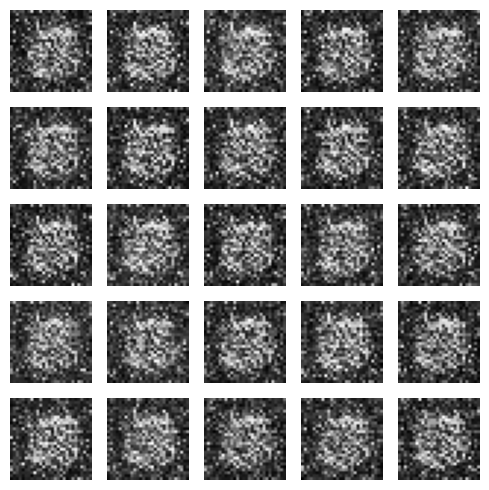

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iteration 101: Accept (Loss -1.2442 <= -1.2367)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Iteration 102: Accept despite loss increase (0.64 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━

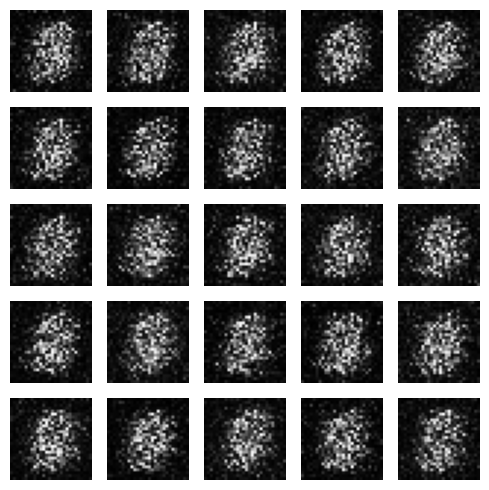

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iteration 201: Accept (Loss -1.5068 <= -1.3320)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iteration 202: Accept (Loss -1.6097 <= -1.4457)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33

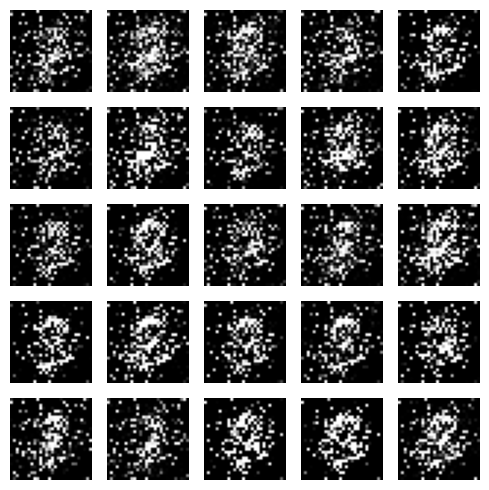

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iteration 301: Accept (Loss -2.2496 <= -1.8599)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Iteration 302: Reject (Loss -2.0110 > -2.2207)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42m

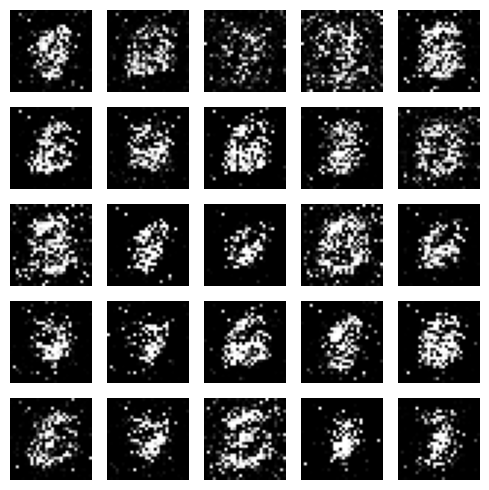

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Iteration 401: Reject (Loss -7.5869 > -7.9018)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Iteration 402: Reject (Loss -7.1225 > -7.7366)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms

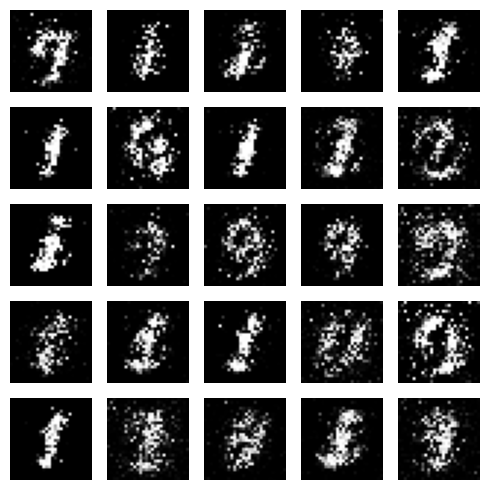

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Iteration 501: Reject (Loss -5.5758 > -5.7582)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Iteration 502: Reject (Loss -5.4146 > -5.9067)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms

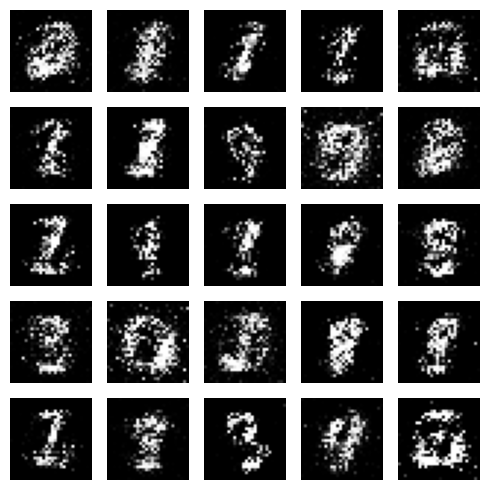

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Iteration 601: Reject (Loss -2.4572 > -2.7736)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 602: Accept despite loss increase (0.11 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━

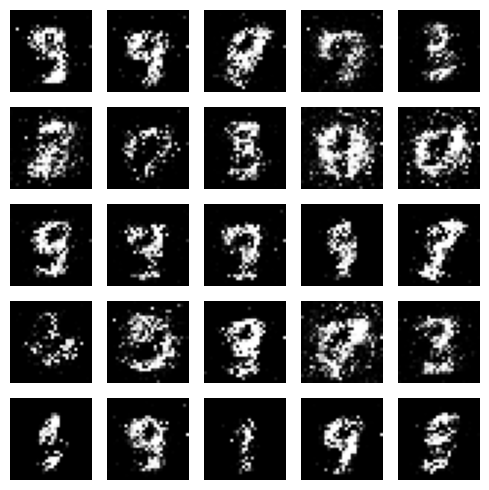

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iteration 701: Reject (Loss -1.4023 > -1.7559)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iteration 702: Reject (Loss -1.4899 > -1.6354)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms

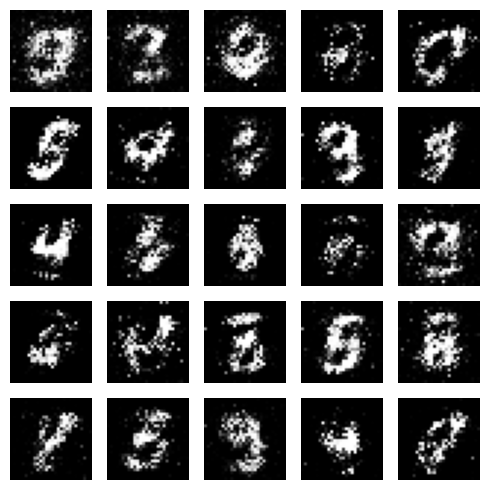

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iteration 801: Reject (Loss -1.0293 > -1.1733)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iteration 802: Accept (Loss -1.1500 <= -1.1342)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42m

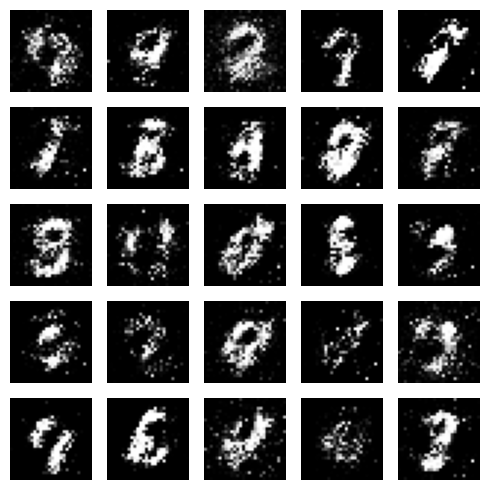

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration 901: Accept (Loss -0.9717 <= -0.9686)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration 902: Accept despite loss increase (0.89 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━

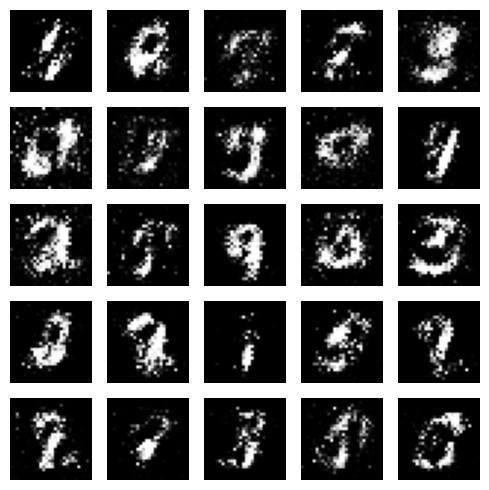

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 1001: Reject (Loss -1.0871 > -1.1744)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Iteration 1002: Accept despite loss increase (0.22 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━

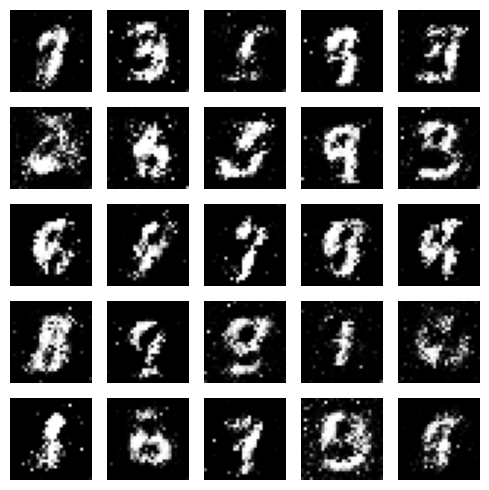

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iteration 1101: Accept despite loss increase (0.47 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iteration 1102: Accept (Loss -1.0236 <= -0.9874)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━

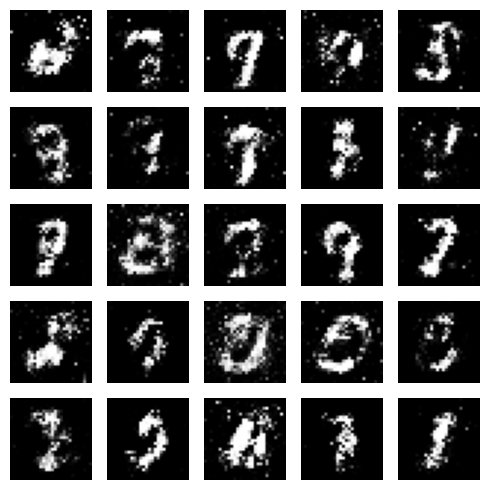

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iteration 1201: Accept (Loss -1.0498 <= -0.9382)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iteration 1202: Accept (Loss -1.1524 <= -0.9663)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

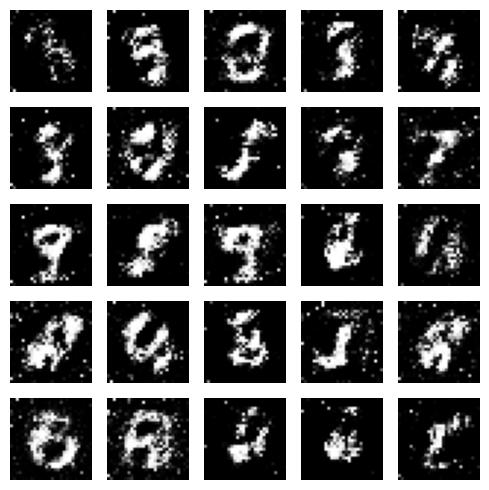

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 1301: Reject (Loss -1.1039 > -1.1889)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Iteration 1302: Accept despite loss increase (0.78 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━

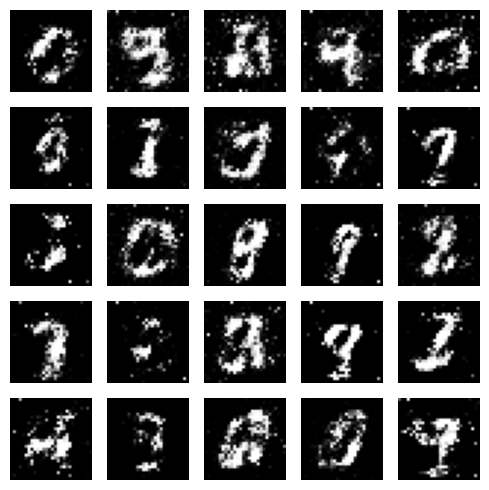

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iteration 1401: Accept despite loss increase (0.53 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iteration 1402: Accept (Loss -1.0892 <= -0.9329)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━

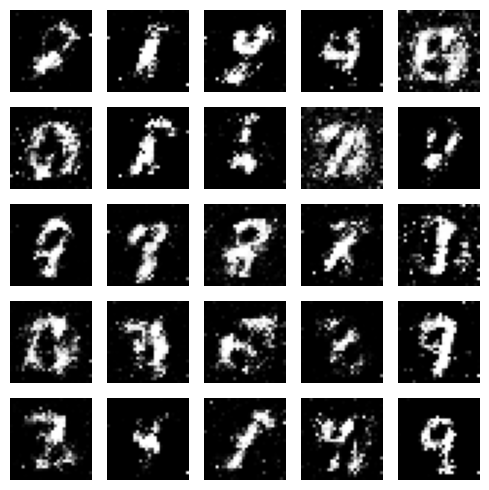

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iteration 1501: Accept despite loss increase (0.64 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration 1502: Accept despite loss increase (0.79 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/ste

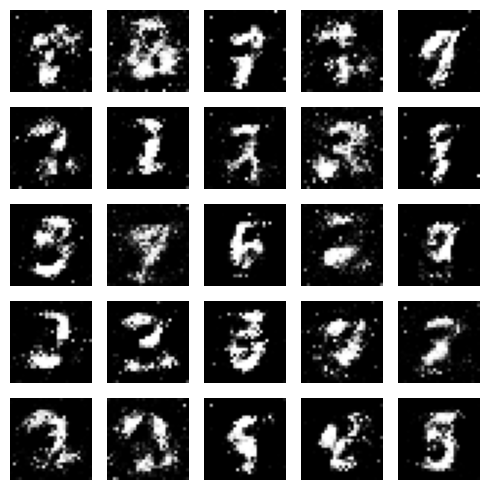

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 1601: Reject (Loss -1.0119 > -1.0739)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 1602: Accept (Loss -1.2044 <= -1.1086)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3

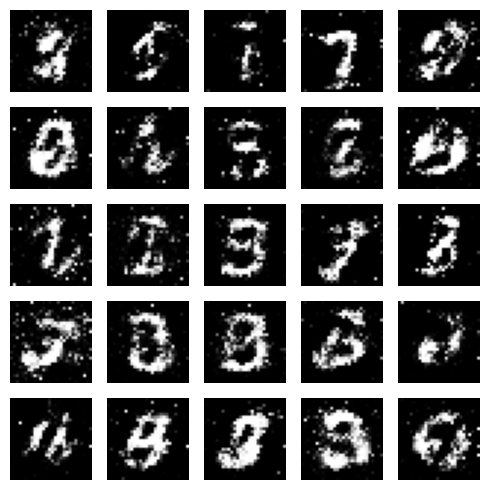

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iteration 1701: Reject (Loss -1.0694 > -1.1457)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iteration 1702: Reject (Loss -1.0409 > -1.1642)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37

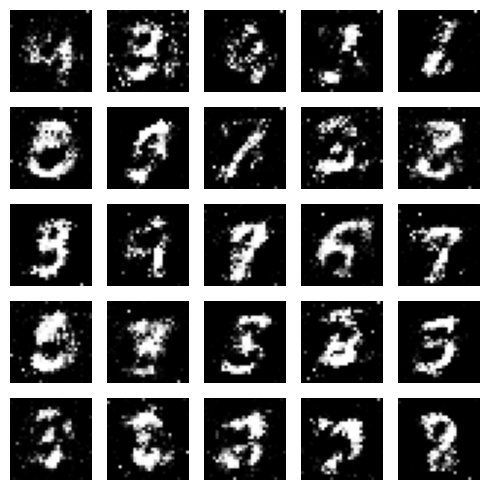

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iteration 1801: Reject (Loss -0.9932 > -1.1736)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Iteration 1802: Accept (Loss -1.1411 <= -1.1274)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4

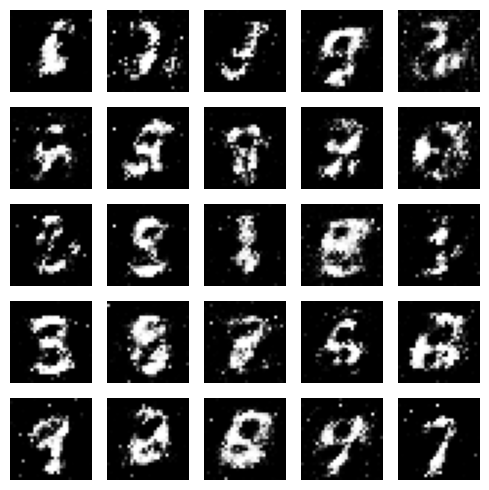

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Iteration 1901: Accept despite loss increase (0.54 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iteration 1902: Accept (Loss -1.0867 <= -1.0183)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━

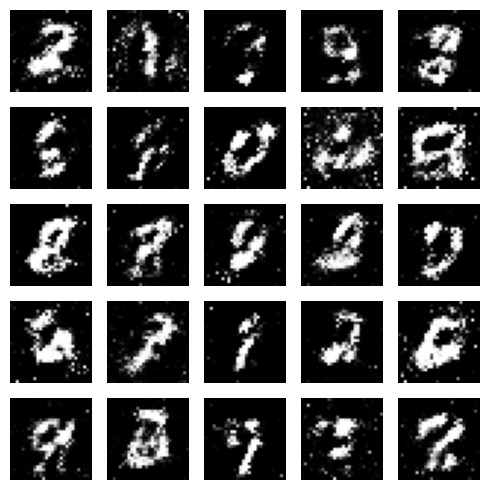

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iteration 2001: Accept (Loss -1.0887 <= -0.9760)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iteration 2002: Accept despite loss increase (0.79 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━

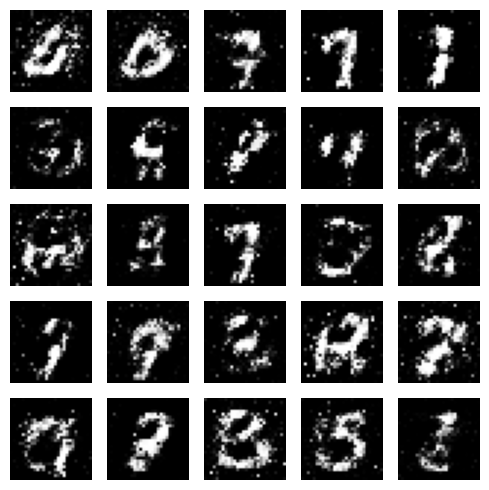

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Iteration 2101: Accept (Loss -1.1865 <= -1.0887)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iteration 2102: Accept (Loss -1.1241 <= -1.1218)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

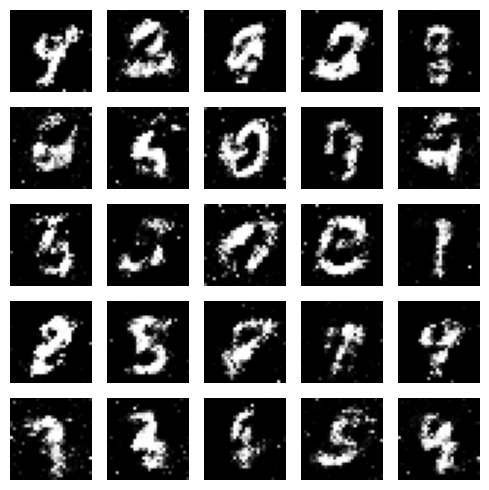

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 2201: Accept despite loss increase (0.98 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration 2202: Accept (Loss -1.1977 <= -1.1178)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━

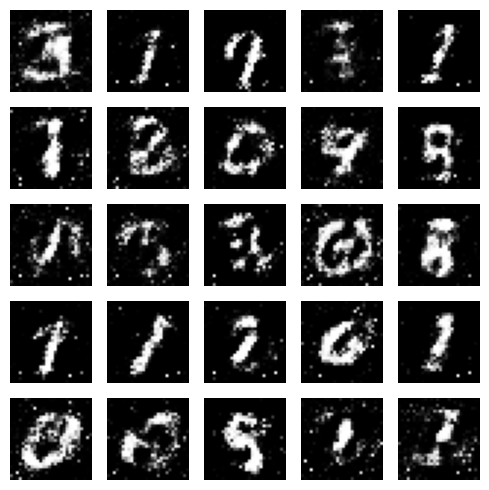

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iteration 2301: Accept (Loss -1.1957 <= -1.1555)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 2302: Accept (Loss -1.1761 <= -1.1427)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

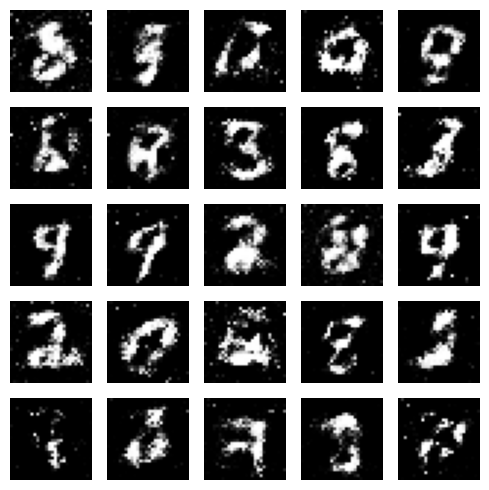

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 2401: Accept despite loss increase (0.67 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iteration 2402: Accept (Loss -1.0887 <= -1.0880)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━

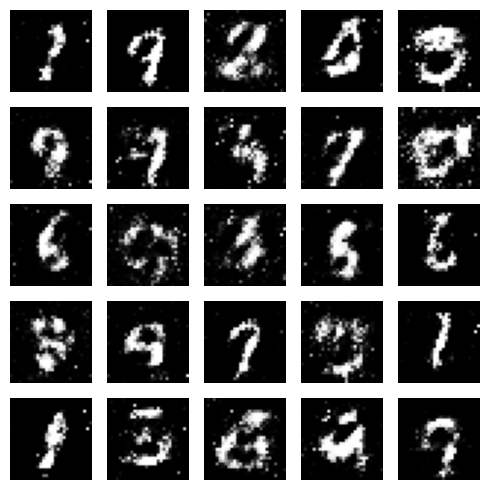

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Iteration 2501: Accept (Loss -1.1572 <= -1.0936)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Iteration 2502: Accept despite loss increase (0.51 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━

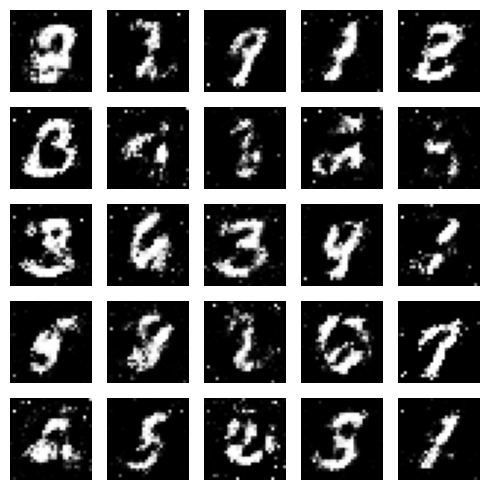

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Iteration 2601: Accept despite loss increase (0.82 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iteration 2602: Accept (Loss -1.2233 <= -1.2116)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━

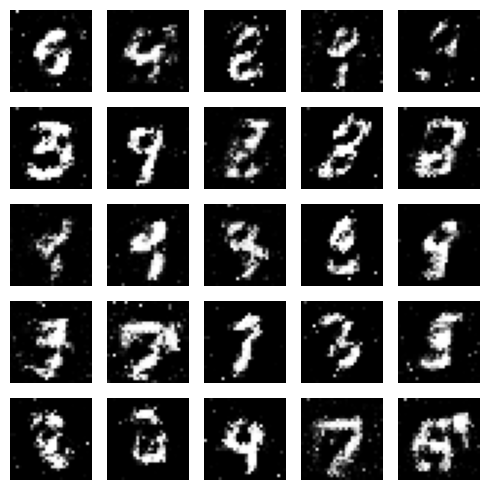

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iteration 2701: Accept (Loss -1.3084 <= -1.1593)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iteration 2702: Accept (Loss -1.2459 <= -1.1262)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

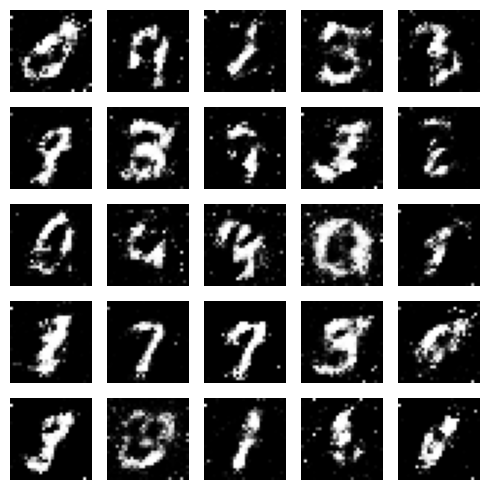

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iteration 2801: Accept (Loss -1.1554 <= -1.1530)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iteration 2802: Accept despite loss increase (0.68 probability)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━

In [ ]:

K.clear_session()
reps = 5
ones_mx = []
# Add lists to track FID and IS metrics across repetitions
all_fid_scores = []
all_is_means = []
all_is_stds = []

for i in tqdm(range(reps)):
    print(f"\nStarting repetition {i+1}/{reps}")
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
    getLoss2 = partial(getLoss, X_train=X)
    create_gan2 = partial(create_gan, opt=adam_optimizer)

    def create_GAN_player():
        print("Creating GAN player...")

        # Create fresh optimizers for each model
        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        gan_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        # Create generator and discriminator with their own optimizers
        gen = create_generator(OUTPUT_SIZE=IMAGE_SIZE, opt=gen_optimizer)
        print(f"Generator created with input shape: {gen.input_shape}")

        disc = create_discriminator(INPUT_SIZE=IMAGE_SIZE, opt=disc_optimizer)
        print(f"Discriminator created with input shape: {disc.input_shape}")

        # Now create the Players object
        print("Creating Players object...")
        ganPlayer = Players(gen, disc, create_gan2, take_generator_steps,
                          take_discriminator_steps_2, change_network,
                          change_network, perturb_generator)
        print("Players object created successfully")

        return ganPlayer

    # Unpack the additional metrics from the training function
    ganPlayerGD_mx, losses_mx, ones, fid_scores, is_means, is_stds = training_gd_mx(create_GAN_player, create_GAN_player, T=10000)

    ones_mx.append(list(ones))
    all_fid_scores.append(list(fid_scores))
    all_is_means.append(list(is_means))
    all_is_stds.append(list(is_stds))

    # Plot the final generated images with metrics
    plot_generated_images(10000, ganPlayerGD_mx.get_x(), save=False, calculate_metrics=True)

    # Only plot metrics if we have data
    if fid_scores and is_means:
        # Plot FID and IS metrics over training
        plt.figure(figsize=(12, 5))

        # Plot FID scores
        plt.subplot(1, 2, 1)
        iterations = range(0, 10000+1, 500)[1:len(fid_scores)+1]
        plt.plot(iterations, fid_scores)
        plt.title(f'FID Score Over Training (Rep {i+1})')
        plt.xlabel('Iteration')
        plt.ylabel('FID Score (lower is better)')

        # Plot IS scores with error bars
        plt.subplot(1, 2, 2)
        plt.errorbar(iterations, is_means, yerr=is_stds, capsize=5)
        plt.title(f'Inception Score Over Training (Rep {i+1})')
        plt.xlabel('Iteration')
        plt.ylabel('IS Score (higher is better)')

        plt.tight_layout()
        plt.show()